# Open Ocean
# Open Earth Fundation

<h1> Step 2: calculate different metrics for each modulating factor </h1>
    
This notebook is the second part of the Step1_Curate_IUCN_RedList.ipynb

<h2> Modulating Factor 3.1: Endemic Species  </h2>

Endemic species are those that are exclusively found in a particular geographic region and nowhere else in the world. It is crucial to understand endemic species in order to maintain the planet's biodiversity, inform conservation efforts, advance our knowledge of evolutionary processes, and recognize the cultural and economic significance of these species. Endemic species in the ocean are difficult to find because they have more freedom of movement than species on land. Consequently, endemism is an important factor to consider when evaluating the importance of protecting a specific place in the ocean. 

### Data needed for this project

The data was output by `Step1_Curate_IUCN_RedList.ipynb` and are accessed through the Oceans Program s3 public bucket

- IUCN Red List dataset for ACMC:
1. s3://ocean-program/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp
2. https://ocean-program.s3.amazonaws.com/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp


- Our Marine Protected Area of interest -> ACMC polygon:

https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson

### 1. Importing libraries

In [3]:
import os
import boto3

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

In [4]:
import fiona; #help(fiona.open)

OEF functions

In [5]:
from MBU_utils import *

### 2. Load data

**Get the conservation area**

Mostly for plotting.

**Coordinates for Cocos Island**

Cocos Island is located at 05°31′41″N; 87°03′40″W

In [ ]:
Cocos_lat = 5+31/60+41/3600
Cocos_lon = -(87+3/60+40/3600)
Cocos = Point(Cocos_lon, Cocos_lat)

**Import the entire marine protected area**

ACMC is the acronyms for the entire conservation area: Cocos Marine Conservation Area

In [6]:
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

In [7]:
ACMC.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Get the species data**

This is the outcome from [Step1_Curate_IUCN_RedList.ipynb](https://github.com/Open-Earth-Foundation/oceanprogram/blob/main/Marine%20Biodiversity%20Unit%20Methodology/Step1_Curate_IUCN_RedList.ipynb)

The species information file is large (~2.1 GB), so trying to access it from the public AWS S3 bucket 'directly' can be time consuming.

Two options:
1. Have patience and run it anyway
2. Download the file in your computer and read it locally

**Option 1**

In [ ]:
%%time
df = gpd.read_file('s3://ocean-program/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp') 

**Option 2**

In [ ]:
# Initialize S3 client
s3 = boto3.client('s3')

# Set the name of the bucket and the path to the directory
bucket_name = 'ocean-program'
directory_path = 'data/processed/ACMC_IUCN_RedList/'

# List all files in the directory
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=directory_path)

# Download each file
for obj in response['Contents']:
    # Skip directories
    if obj['Key'].endswith('/'):
        continue
    
    # Download the file
    file_name = obj['Key'].split('/')[-1]
    s3.download_file(ocean-program, obj['Key'], file_name)
    print(f"Downloaded file: {file_name}")

The downloaded files will be saved in the current working directory, so to read it:

In [ ]:
%%time
df = gpd.read_file('./gdf_ACMC_IUCN_range_status_filtered.shp') 

### 3. Preliminary calculations

In [ ]:
area_of_conservation = ACMC.geometry.item()

In [ ]:
area_of_conservation

Note: Maybe this modulating factor can have another name, because we can obtain more information from it, as local species or migratory species.

**Distribution Ratio #2**

Let's to define a distribution ratio based on the distribution area within total conservation area and the total distribution area for each species:

DistRatio 2 = $\frac{\text{distribution area within total conservation area}}{\text{total distribution area}}$

**Analysis - Scenarios**

Here we can have 3 scenarios:

1. `Distribution Ratio 2 > 1`
- This does not make sense because it implies that the range of the species within the total conservation area is greater than its total range.
2. `Distribution Ratio 2 = 1` 
- This implies that both areas are the same, so that the species is endemic to the conservation area.
3. `Distribution Ratio 2 < 1` 

    3.1 When Distribution `Ratio 2 is close to 1`: 
- This means that these species are not endemic to the conservation area, but could be considered local species (for example, the Eastern Central Pacific).

    3.2 When Distribution `Ratio 2 << 1`: 
- These species are migratory
- They might visit the conservation area seasonally and they can travel long distances
- You can find them in other parts of the ocean around the world

Maps examples: https://towardsdatascience.com/plot-choropleth-maps-with-shapefiles-using-geopandas-a6bf6ade0a49
https://stackoverflow.com/questions/65507374/plotting-a-geopandas-dataframe-using-plotly

**Removing all the geometries outside ACMC**

In [26]:
df = df[0:100]

In [ ]:
df2 = gpd.clip(df.set_crs(epsg=4326, allow_override=True), ACMC)

In [13]:
#Grid geo Dataframe
grid = create_grid(ACMC, 'hexagon', 1)

In [20]:
def mbu_endemism(roi, gdf, grid_gdf, transform="log"):
    """
    inputs:
    roi <shapely polygon in CRS WGS84:EPSG 4326>: region of interest or the total project area
    gdf <geopandas dataframe>: contains at least the name of the species and the distribution polygons of each of them
    grid_gdf <geopandas dataframe>: consists of polygons of grids typically generated by the gridding function
                                  : containts atleast a geometry column and a unique grid_id
    transform <str>: either "none" or "square-root" or "log"
                   : if "square-root" then it is square-rooted
                   : else 1/(-Log2(score))
               
    output(s):
    gdf <geopandas dataframe>: with an additional column ('mbu_endemism') containing the number
                             :of units for that grid or geometry
    """
    
    #Polygons of species distribution to be clipped to roi
    df2 = gpd.clip(gdf.set_crs(epsg=4326, allow_override=True), roi)
    
    #Calculate the portion of the area covered by each species in roi with respect to its global distribution
    dist_ratio2 = np.round(df2.area/gdf.area, decimals=4, out=None)
    
    if transform == "none":
        
        #Add these values into the new gdf
        df2["dist_ratio2"] = dist_ratio2
        
        #Function that calculates the sum of the individual log_dist2 values of all species of overlapping geometries
        overlap_endemic_v = sum_values(df2,'dist_ratio2')
        
    elif transform == "log":
        
        #Calculate the log of that ratio
        log_dist2 = 1/(-np.log2(dist_ratio2)+0.1)
    
        #Add these values into the new gdf
        df2["log_dist2"] = log_dist2
    
        #Function that calculates the sum of the individual log_dist2 values of all species of overlapping geometries
        overlap_endemic_v = sum_values(df2,'log_dist2')
        
    elif transform == "square-root":
            
        #Calculate the log of that ratio
        sqroot_dist2 = dist_ratio2**0.5
    
        #Add these values into the new gdf
        df2["sqroot_dist2"] = sqroot_dist2
    
        #Function that calculates the sum of the individual log_dist2 values of all species of overlapping geometries
        overlap_endemic_v = sum_values(df2,'sqroot_dist2')       
        
    else:
        raise Exception("Specify a none, log or square as the transformation.")
    
    #Merged the log_dist2 values of overlapping geometries with the grid gdf
    merged = gpd.sjoin(overlap_endemic_v, grid_gdf, how='left')
    merged['n_value']= overlap_endemic_v['sum_overlaps']

    # Compute stats per grid cell
    #aggfunc: sum the values of all the geometries that dissolve
    dissolve = merged.dissolve(by="index_right", aggfunc={'n_value': 'sum'})

    #Put this into cell
    grid_gdf.loc[dissolve.index, 'endemism'] = dissolve.n_value.values
    
    return grid_gdf

In [17]:
mbu_endemism(ACMC, df, grid, transform="log")

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_35547/481667131.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_ratio2 = np.round(df2.area/gdf.area, decimals=4, out=None)
/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/maureenfonseca/Desktop/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:196: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


,geometry,Grid_ID,endemism
0,"POLYGON ((-88.32201 2.15063, -88.82201 3.01666...",0,NaN
1,"POLYGON ((-88.32201 3.88268, -88.82201 4.74871...",1,0.000000
2,"POLYGON ((-88.32201 5.61474, -88.82201 6.48076...",2,0.000000
3,"POLYGON ((-88.32201 7.34679, -88.82201 8.21281...",3,0.000000
4,"POLYGON ((-86.82201 1.28461, -87.32201 2.15063...",4,NaN
5,"POLYGON ((-86.82201 3.01666, -87.32201 3.88268...",5,0.000000
6,"POLYGON ((-86.82201 4.74871, -87.32201 5.61474...",6,11952.095261
7,"POLYGON ((-86.82201 6.48076, -87.32201 7.34679...",7,14479.794850
8,"POLYGON ((-86.82201 8.21281, -87.32201 9.07884...",8,NaN
9,"POLYGON ((-85.32201 2.15063, -85.82201 3.01666...",9,0.000000


In [21]:
mbu_endemism(ACMC, df, grid, transform="none")

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_35547/3952723412.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_ratio2 = np.round(df2.area/gdf.area, decimals=4, out=None)
/Users/maureenfonseca/Desktop/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:196: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


,geometry,Grid_ID,endemism
0,"POLYGON ((-88.32201 2.15063, -88.82201 3.01666...",0,NaN
1,"POLYGON ((-88.32201 3.88268, -88.82201 4.74871...",1,0.0000
2,"POLYGON ((-88.32201 5.61474, -88.82201 6.48076...",2,0.0000
3,"POLYGON ((-88.32201 7.34679, -88.82201 8.21281...",3,0.0000
4,"POLYGON ((-86.82201 1.28461, -87.32201 2.15063...",4,NaN
5,"POLYGON ((-86.82201 3.01666, -87.32201 3.88268...",5,0.0000
6,"POLYGON ((-86.82201 4.74871, -87.32201 5.61474...",6,3406.6474
7,"POLYGON ((-86.82201 6.48076, -87.32201 7.34679...",7,4068.8618
8,"POLYGON ((-86.82201 8.21281, -87.32201 9.07884...",8,NaN
9,"POLYGON ((-85.32201 2.15063, -85.82201 3.01666...",9,0.0000


In [22]:
test = mbu_endemism(ACMC, df, grid, transform="square-root")

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_35547/3952723412.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_ratio2 = np.round(df2.area/gdf.area, decimals=4, out=None)
/Users/maureenfonseca/Desktop/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:196: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


(-90.57200586479142, -85.07200586479142, 0.9381984227004798, 8.55922197600354)

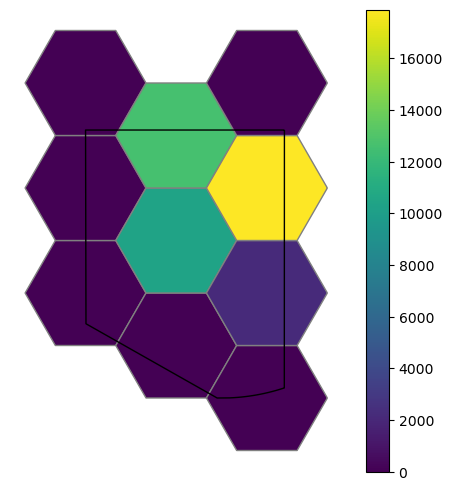

In [25]:
ax = test.plot(column='endemism', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)
#plt.autoscale(False)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

**OBIS data**

In [1]:
from pyobis import occurrences

In [8]:
#create a polygon to access the OBIS data
min_x, min_y, max_x, max_y = ACMC.total_bounds
geometry = f"POLYGON(({max_x} {min_y}, {min_x} {min_y}, {min_x} {max_y}, {max_x} {max_y}, {max_x} {min_y}))"

In [9]:
#Grid geo Dataframe
grid = create_grid(ACMC, 'hexagon', 1)

In [10]:
query = occurrences.search(geometry=geometry)
query.execute()

Fetching: [████████████████████████████████████████████████████████████████████████████████████████████████████] 4216/4216
Fetched 4216 records.


,rightsHolder,infraphylum,country,date_year,scientificNameID,scientificName,individualCount,dropped,gigaclassid,aphiaID,...,sectionid,subsectionid,minimumElevationInMeters,maximumElevationInMeters,hab,varietyid,variety,parvorder,parvorderid,associatedMedia
0,CAS,Gnathostomata,Costa Rica,1998.0,urn:lsid:marinespecies.org:taxname:293586,Doryrhamphus excisus excisus,1,False,10194.0,293586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIO,Gnathostomata,NaN,1967.0,urn:lsid:marinespecies.org:taxname:306621,Scopelogadus bispinosus,NaN,False,10194.0,306621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KU,Gnathostomata,Costa Rica,1954.0,urn:lsid:marinespecies.org:taxname:125636,Gymnothorax,NaN,False,10194.0,125636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Gnathostomata,NaN,NaN,urn:lsid:marinespecies.org:taxname:105857,Mobula birostris,NaN,False,NaN,1026118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAS,Gnathostomata,Panama,1956.0,urn:lsid:marinespecies.org:taxname:276587,Polydactylus approximans,2,False,10194.0,276587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4211,NaN,Gnathostomata,Costa Rica,1975.0,urn:lsid:marinespecies.org:taxname:276587,Polydactylus approximans,NaN,False,10194.0,276587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,NaN,Gnathostomata,NaN,NaN,urn:lsid:marinespecies.org:taxname:127401,Diodon eydouxii,NaN,False,10194.0,127401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4213,LACM,Gnathostomata,Costa Rica,1964.0,urn:lsid:marinespecies.org:taxname:276400,Dactyloscopus lacteus,1,False,10194.0,276400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4214,NaN,Gnathostomata,NaN,1925.0,NaN,Idiacanthus antrostomus,1,False,10194.0,275151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Returns the data
obis = query.data 

In [13]:
# convert OBIS dataframe to geodataframe
obis = gpd.GeoDataFrame(obis, 
                       geometry=gpd.points_from_xy(obis.decimalLongitude, 
                                          obis.decimalLatitude))

In [15]:
import random

fake_abundance = [random.randint(1, 100) for _ in range(len(obis))]
obis['abundance'] = fake_abundance

<AxesSubplot:>

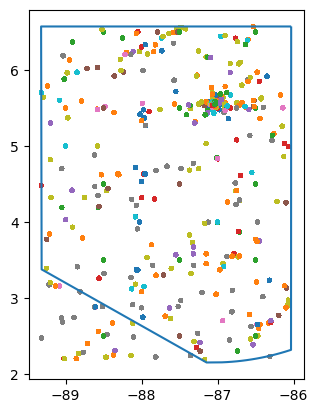

In [16]:
# plot protected area with marine species
# select column name to plot
column_name = 'scientificName'
ax = ACMC.boundary.plot()
obis.plot(ax=ax, markersize=5, column=column_name, 
        antialiased=False, legend_kwds={'bbox_to_anchor': (1, 1)})

In [17]:
#Join in a gdf all the geometries within ACMC
df2 = gpd.clip(obis.set_crs(epsg=4326, allow_override=True), ACMC)